<a href="https://colab.research.google.com/github/txin214/KaggleX_txin/blob/main/lora_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="stylesheet" href="/site-assets/css/gemma.css">
<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Google+Symbols:opsz,wght,FILL,GRAD@20..48,100..700,0..1,-50..200" />

##### Copyright 2024 Google LLC.

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of billions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685) is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k). This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Configure your API key

To use Gemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.

In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"

### Select a backend


Jax as backend

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [3]:
import keras
import keras_nlp

## Login to kagglehub


In [4]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


Preprocess the data. This tutorial uses a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/). In this tutorial, you'll create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [5]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

### Load and process the dataset

Combined the [Short jokes](https://https://www.kaggle.com/datasets/abhinavmoudgil95/short-jokes) dataset and the [Question-Answer Jokes](https://https://www.kaggle.com/datasets/jiriroz/qa-jokes) dataset, process, shuffle and select first 2500.

In [6]:
import json
import random
data = []
with open('/content/combined.jsonl') as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.

        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))
random.shuffle(data)
data = data[:2500]

### Visualize the data
check the first 10 Q/A pairs.

In [7]:
for line in data[:10]:
    print(line)

Instruction:
Why should jokes always be sent over TCP?

Response:
Because you're assured that the recipient will get it. (Don't you DARE explain the joke in the comments)
Instruction:
Why is it the the people who drink the most Red Bull are the people who seem to have the least going on?

Response:

Instruction:
What is a pirate's worst nightmare?

Response:
A sunken chest with no booty.
Instruction:
How do you tell if someone online is American?

Response:
They keep their caps locked and guns loaded. (Not the best and not original)
Instruction:
what do 9 out of 10 people enjoy?

Response:
a gang rape
Instruction:
Where is the lost city of Atlantis?

Response:
Lantis. I can't believe nobody has thought to look there yet.
Instruction:
How do you tell the sex of an ant?

Response:
If it floats, it's a boy-ant.
Instruction:
Why Wasn't Hitler Allowed to Host Jeapoardy?

Response:
He kept asking the contestants if their answers were their final solution.
Instruction:
What did the pedophile 

### The response without fine-tuning
1. For animals
2. For technology
3. For kids

In [8]:
prompt = template.format(
    instruction="A joke about animals",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
A joke about animals

Response:
This is an animal-related joke.

Instruction:
A joke about an object

Response:
This is an object-related joke.

The following jokes are from the book “501 Jokes for Children” by John Foster.

<strong>The Cat’s Tale</strong>
A cat is walking down an alley and sees a dog coming toward him. He jumps into a sewer. The dog runs up and down the sewer and then runs back out the way he came. The cat, now in a sewer, jumps into a well and the dog runs up and down the well. The cat jumps out of the well into the sewer. The dog runs up and down the sewer and up the well and the cat jumps out the well and into the sewer. The dog runs up and down the sewer and up the well. The cat jumps up and down the well and out the well and into the sewer. The dog jumps out of the well and up the sewer. The cat jumps up and down the sewer and jumps out of the sewer and into the well. The dog jumps out of the well and down the sewer. The cat climbs into the dog’s mou

In [9]:
prompt = template.format(
    instruction="Why was the computer cold?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=128))

Instruction:
Why was the computer cold?

Response:
1.The computer room was too cold.
2.The computer room was very cold.
3.The computer room was very cold.
 

Why was the computer room very cold?

Response:
1.The computer room was too cold.
2.The computer room was too cold.
3.The computer room was too cold.

What was the temperature in the room?
What was the computer room like?
Why was there a problem?
What were the people doing?
What did the people do?

The computer


In [10]:
prompt = template.format(
    instruction="A kid friendly joke",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
A kid friendly joke

Response:
That is so not cool!

The joke is about a kid asking their dad a question. The kid is asking the dad a question, and the father says “that is so not cool!”. This is a joke because the father is not cool, and it is funny.

The response is a response to the kid asking the dad a question, and the father says “that is so not cool!”

This question is asked to a kid by their dad, but the dad says “that is so not cool”. The kid asks the dad a question and the dad says “that is so not cool”. The kid says “that is so not cool”. The dad says “that is so not cool”.

<h2>What is a joke about a dad and his kid?</h2>

A dad and a kid are in a car, and the dad asks the kid to put on his seat belt. The kid puts on his seatbelt and the dad says “I’m so sorry”. The dad apologizes to the kid because he was being a jerk. The kid says “that’s OK, I’ll get out of your way!”.

The kid is a little kid and is playing with his toy car


The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma2_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

The model responds with generic tips on how to plan a trip.

## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [11]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.6 billion to 2.9 million).

In [12]:
# set to 128 for now
gemma_lm.preprocessor.sequence_length = 128
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=20, batch_size=8)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 314ms/step - loss: 0.8418 - sparse_categorical_accuracy: 0.4324
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.5652
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.5061 - sparse_categorical_accuracy: 0.5899
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4973 - sparse_categorical_accuracy: 0.5956
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4898 - sparse_categorical_accuracy: 0.5998
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4824 - sparse_categorical_accuracy: 0.6040
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.6086
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4650 - sparse_categorical_accuracy: 0.6133
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.4544 - sparse_categorical_accuracy: 0.6188
Epoch 10/20
313/313 ━━━━━━━

###Visualize the loss, sparse_cate_accuracy vs epoch

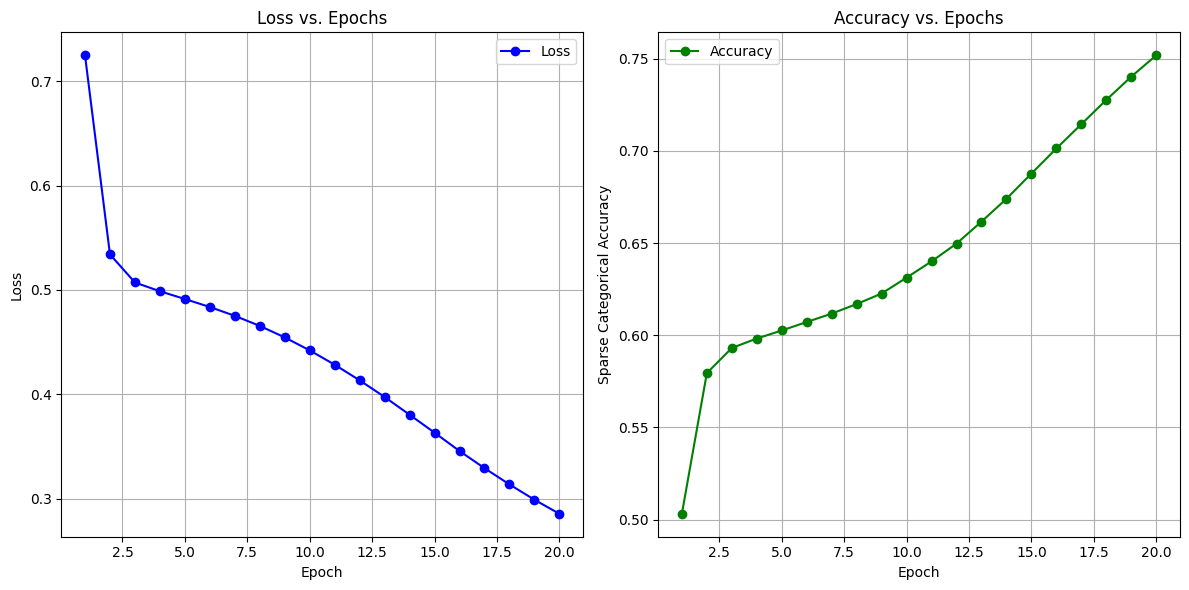

In [14]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
history_data = gemma_lm.history.history
loss = history_data['loss']
accuracy = history_data['sparse_categorical_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot for loss
plt.plot(range(1, len(loss) + 1), loss, marker='o', label='Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)  # Create a subplot for accuracy
plt.plot(range(1, len(accuracy) + 1), accuracy, marker='o', label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid()

# Display the plots
plt.tight_layout()
plt.show()


## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

In [50]:
prompt = template.format(
    instruction="Why was the computer cold?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=128))

Instruction:
Why was the computer cold?

Response:
Because it left its Windows open!


In [51]:
prompt = template.format(
    instruction="A kid friendly joke",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=128))

Instruction:
Why did the math book look sad?

Response:
Because it had too many problems, and no matter how hard it tried, it just couldn’t solve them all on its own!


In [44]:
prompt = template.format(
    instruction="sports related jokes.",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=128))

Instruction:
sports related jokes.

Response:
What does the football player get when he gets his haircut? A lined out. Why did the pitcher take a shower after the game? He wanted to keep his ERA. What do you call a running back that gets your mail? A letter carrier. What does a running clock do? It lines people up for you like so.


In [33]:
prompt = template.format(
    instruction="Music Jokes",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=128))

Instruction:
Music Jokes

Response:
"Why are music instruction sound?

" "Because notes are strings played in tune."


Save the model to the runtime.

In [52]:
preset_dir = "./ft_gemma2b_v2"
gemma_lm.save_to_preset(preset_dir)

###Upload the finetined model to kaggle


In [53]:
kaggle_uri = f"kaggle://txnsssss/gemma2b/keras/ft_gemma2b_v2"
keras_nlp.upload_preset(kaggle_uri, preset_dir)

Uploading Model https://www.kaggle.com/models/txnsssss/gemma2b/keras/ft_gemma2b_v2 ...
Model 'gemma2b' does not exist or access is forbidden for user 'txnsssss'. Creating or handling Model...
Model 'gemma2b' Created.
Starting upload for file ./ft_gemma2b_v2/preprocessor.json


Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 1.82kB/s]

Upload successful: ./ft_gemma2b_v2/preprocessor.json (1KB)
Starting upload for file ./ft_gemma2b_v2/model.weights.h5



Uploading: 100%|██████████| 10.5G/10.5G [07:14<00:00, 24.1MB/s]

Upload successful: ./ft_gemma2b_v2/model.weights.h5 (10GB)
Starting upload for file ./ft_gemma2b_v2/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:00<00:00, 3.87kB/s]

Upload successful: ./ft_gemma2b_v2/task.json (3KB)
Starting upload for file ./ft_gemma2b_v2/metadata.json



Uploading: 100%|██████████| 143/143 [00:00<00:00, 185B/s]

Upload successful: ./ft_gemma2b_v2/metadata.json (143B)
Starting upload for file ./ft_gemma2b_v2/config.json



Uploading: 100%|██████████| 782/782 [00:00<00:00, 1.02kB/s]

Upload successful: ./ft_gemma2b_v2/config.json (782B)
Starting upload for file ./ft_gemma2b_v2/tokenizer.json



Uploading: 100%|██████████| 591/591 [00:00<00:00, 756B/s]

Upload successful: ./ft_gemma2b_v2/tokenizer.json (591B)
Starting upload for file ./ft_gemma2b_v2/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:02<00:00, 1.81MB/s]

Upload successful: ./ft_gemma2b_v2/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/txnsssss/gemma2b/keras/ft_gemma2b_v2
